In [1]:
#Download the sas7bdat file into SAS Viya Workbench
import requests

# File path and name
file_path = r"/workspaces/myfolder/Bees/dst6.sas7bdat"
 
# Specify the URL of the CSV file
url = r"https://github.com/CharuSAS/SASPythonDataScientists/raw/main/dst6.sas7bdat"
 
# Download the and save CSV file to Workbench
response = requests.get(url)
with open(file_path, 'wb') as f:
    f.write(response.content)
    print(f'File downloaded:{file_path}')

File downloaded:/workspaces/myfolder/Bees/dst6.sas7bdat


In [2]:
#Load data into a pandas dataframe
import pandas as pd
import numpy as np

df = pd.read_sas(r"/workspaces/myfolder/Bees/dst6.sas7bdat", encoding='latin-1')

For this machine learning example we want to predict whether we might find non-native bees in a sample, based on properties of the vegetation and the environment where we do the sample. This does assume we will find a bee in the sample, so we include as an input what kind of nest is present in the environment, but we don't include the species. The goal is to build a model to predict whether any non-native bees will be found.

In [3]:
#only keep columns we plan use for ML
df = df[['no of specimens in sample','date','year', 'season','site','plot','sampling','vegetation cover','floral cover','height of vegetation (cm)','non-native bee']]

In [4]:
#This will be our dataset for modeling, notice all of the missing values
df.head()

,no of specimens in sample,date,year,season,site,plot,sampling,vegetation cover,floral cover,height of vegetation (cm),non-native bee
0,NaN,2016-09-21,2016.0,late.season,A,non-native,hand netting,NaN,NaN,NaN,NA
1,NaN,2016-09-21,2016.0,late.season,B,non-native,hand netting,NaN,NaN,NaN,NA
2,NaN,2016-09-21,2016.0,late.season,C,non-native,hand netting,NaN,NaN,NaN,NA
3,NaN,2016-09-21,2016.0,late.season,C,native,hand netting,NaN,NaN,NaN,NA
4,NaN,2016-09-21,2016.0,late.season,C,native,hand netting,NaN,NaN,NaN,NA


In [5]:
#Let's do some type conversion to clean up the data
print('Initial dtypes:\n', df.dtypes)

df['non-native bee'] = pd.to_numeric(df['non-native bee'], errors='coerce')
df['no of specimens in sample'] = pd.to_numeric(df['no of specimens in sample'])
df['height of vegetation (cm)'] = pd.to_numeric(df['height of vegetation (cm)'])

Initial dtypes:
 no of specimens in sample           object
date                         datetime64[s]
year                               float64
season                              object
site                                object
plot                                object
sampling                            object
vegetation cover                    object
floral cover                        object
height of vegetation (cm)           object
non-native bee                      object
dtype: object


In [6]:
#This will be our binary target variable, so let's drop missing values here
print(df['non-native bee'].value_counts())

df.dropna(axis=0, subset='non-native bee', inplace=True)

non-native bee
0.0    3022
1.0     558
Name: count, dtype: int64


In [7]:
#Let's process the date variable to create a month variable for use in ML, and then drop the date variable
df['month'] = df['date'].dt.month
df.drop('date', axis=1, inplace=True)

In [8]:
#The sasviya.ml package prefers pandas dataframe, so change sklearn output to use dataframes
import sklearn
sklearn.set_config(transform_output="pandas")

In [9]:
#We use sklearn to partition the data into training and validation data
from sklearn.model_selection import train_test_split

X = df.drop('non-native bee', axis=1)
y = df['non-native bee']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=919)

print("Training data shape:", X_train.shape, "\n" + "Validation data shape:", X_valid.shape)

Training data shape: (2506, 10) 
Validation data shape: (1074, 10)


In [10]:
#fit a gradient boosting model
#Note that we can skip imputation for this tree-based model since it can handle missing values
from sasviya.ml.tree import GradientBoostingClassifier

model = GradientBoostingClassifier(calc_feature_importances=True)

In [11]:
#Fit the model using the training data
model.fit(X_train, y_train)

GradientBoostingClassifier(calc_feature_importances=True)

In [12]:
#Evaluate model performance on the validation data
y_pred = model.predict_proba(X_valid)
valid_out = y_pred.join(y_valid)

train_out = model.predict_proba(X_train).join(y_train)

In [13]:
valid_out.head()

,P_non_native_bee0,P_non_native_bee1,non-native bee
2573,0.953078,0.046922,0.0
905,0.994508,0.005492,0.0
1895,0.983026,0.016974,0.0
2435,0.998956,0.001044,0.0
1429,0.965854,0.034146,0.0


In [14]:
#Calculate misclassification for 'champion' model on validation data
from sklearn.metrics import accuracy_score

cutoff = 0.5
valid_preds = [1 if valid_out['P_non_native_bee1'][elem] > cutoff else 0 for elem in valid_out.index]

print('Misclassification Rate on Validation Data for Gradient Boosting at',cutoff,'cutoff:', 1-accuracy_score(valid_out['non-native bee'], valid_preds))

Misclassification Rate on Validation Data for Gradient Boosting at 0.5 cutoff: 0.04003724394785846


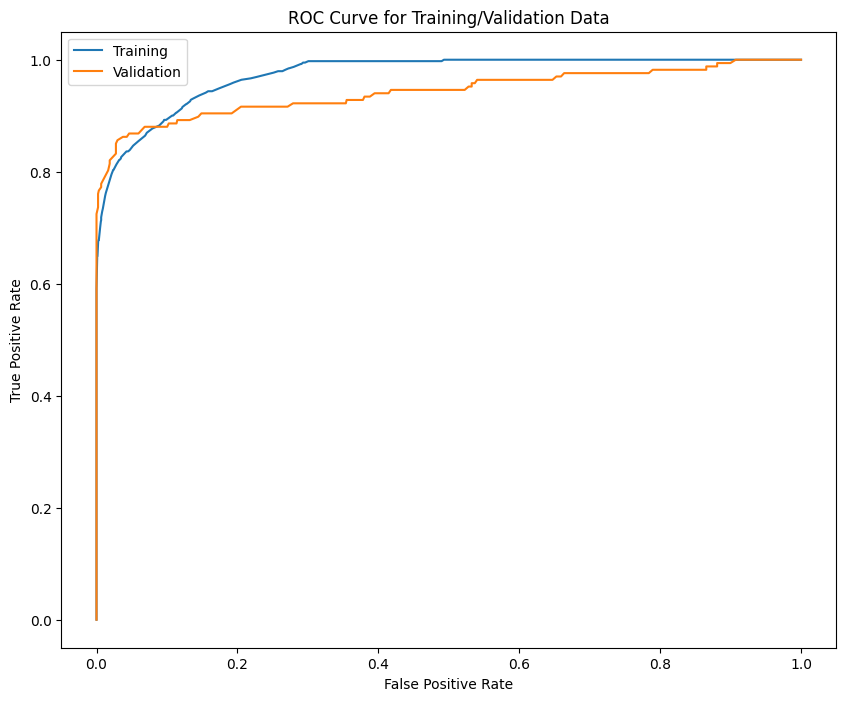

In [15]:
#plot ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Training/Validation Data')

train_roc = roc_curve(train_out['non-native bee'], train_out['P_non_native_bee1'], pos_label=1)
valid_roc = roc_curve(valid_out['non-native bee'], valid_out['P_non_native_bee1'], pos_label=1)


plt.plot(train_roc[0], train_roc[1])
plt.plot(valid_roc[0], valid_roc[1])
plt.legend(['Training','Validation']);

In [16]:
#Explore variable importance table to understand the model
model.feature_importances_

,Variable,Importance,Std,Count
0,no of specimens in sample,14.160217,37.920309,266.0
1,plot,2.833015,12.418197,71.0
2,floral cover,2.775160,2.484855,244.0
3,month,2.205808,3.926887,155.0
4,vegetation cover,1.767559,1.217433,202.0
5,site,1.245338,1.083839,169.0
6,sampling,0.355896,0.651035,50.0
7,height of vegetation (cm),0.332582,0.594849,55.0
8,season,0.215867,0.586847,28.0
